In [1]:
import os 
import xarray as xr
from joblib import Parallel, delayed
import multiprocessing
import glob
import pandas as pd

In [2]:
z_s = xr.open_dataset("/work/uc1275/u301827/02_MSE/surface_geopotential_zs.nc")

In [47]:
# === Edit these paths if different ===
final_path = "/work/uc1275/u301827/02_MSE/PNW"
zs_file    = "/work/uc1275/u301827/02_MSE/surface_geopotential_zs_regrid.nc"

# Variable mapping (as you provided)
era5_vars = {
    130: "t",   # Temperature, pl @ 500 hPa
    129: "z",   # Geopotential, pl @ 500 hPa
    133: "q",   # Specific humidity, ml @ level 137
    167: "2t",  # 2m temperature, surface (no levels)
}

def _find_sel_file(var_name, date_str, base_dir=final_path):
    """Return the path to sel_{var}_{YYYY-MM-DD}_level.nc or raise FileNotFoundError."""
    pattern = os.path.join(base_dir, var_name, f"sel_{var_name}_{date_str}_level.nc")
    matches = glob.glob(pattern)
    if not matches:
        raise FileNotFoundError(f"No file found for variable '{var_name}' and date '{date_str}'. looked for: {pattern}")
    if len(matches) > 1:
        # pick first but warn
        print(f"Warning: multiple matches for {pattern}. Using {matches[0]}")
    return matches[0]

def open_era5_day(date, era5_vars=era5_vars, zs_file=zs_file, final_path=final_path):
    """
    Open all preprocessed ERA5 variable files for one day plus the surface geopotential file.
    Parameters
    ----------
    date : str or pd.Timestamp
      e.g. "2021-06-21" or pd.Timestamp("2021-06-21")
    Returns
    -------
    dict with keys:
      - 'datasets': dict mapping var_name -> xarray.Dataset (opened)
      - 'zs': xarray.DataArray or Dataset (surface geopotential, time removed if present)
      - 'date_str': the 'YYYY-MM-DD' string used
    """
    if isinstance(date, pd.Timestamp):
        date_str = date.strftime("%Y-%m-%d")
    else:
        # accept "YYYY-MM-DD" or similar
        date_str = pd.to_datetime(date).strftime("%Y-%m-%d")

    datasets = {}
    for varnum, varname in era5_vars.items():
        try:
            path = _find_sel_file(varname, date_str, base_dir=final_path)
        except FileNotFoundError as e:
            # re-raise with clearer message
            raise FileNotFoundError(f"Missing preprocessed file for var '{varname}' on {date_str}: {e}")
        ds = xr.open_dataset(path)
        datasets[varname] = ds
 
    # open surface geopotential and drop any time dimension if present
    if not os.path.exists(zs_file):
        raise FileNotFoundError(f"Surface geopotential file not found: {zs_file}")
    ds_zs = xr.open_dataset(zs_file).rename({'valid_time':'time'})
  
    # pick sensible variable from zs (if more than one) - prefer common names, else first
    zs_var_candidates = [v for v in ("z_s", "surface_geopotential", "geopotential", "phi", "zg") if v in ds_zs]
    zs_var = zs_var_candidates[0] if zs_var_candidates else list(ds_zs.data_vars)[0]
    zs = ds_zs[zs_var]

    # If time exists and is length 1 or time-invariant, drop time (select first step)
    if "time" in zs.dims:
        if zs.sizes["time"] == 1:
            zs = zs.isel(time=0)
        else:
            # if there are multiple time steps but they are identical, pick first; otherwise warn and pick first
            try:
                if (zs - zs.isel(time=0)).sum().values == 0:
                    zs = zs.isel(time=0)
                    print("zs had multiple identical time slices; selected the first one.")
                else:
                    print("Warning: zs has multiple different time slices; selecting the first timestep (isel(time=0)).")
                    zs = zs.isel(time=0)
            except Exception:
                print("Warning: unable to compare zs time slices; selecting first timestep (isel(time=0)).")
                zs = zs.isel(time=0)

    return {"datasets": datasets, "zs": zs, "date_str": date_str}

# -----------------------
# Example usage:
# res = open_era5_day("2021-06-21")
# ds_2t = res['datasets']['2t']
# ds_q  = res['datasets']['q']
# ds_t500 = res['datasets']['t']   # 500 hPa temperature (if your 't' file contains it)
# zs = res['zs']
# -----------------------

In [48]:
def prepare_zs_for_surface_mse(res):
    """
    Align the time-invariant surface geopotential (zs) with the 2t dataset,
    so it can be broadcast safely without causing memory blowup.
    """
    ds_2t = res["datasets"]["2t"]
    zs = res["zs"]

    # Drop any existing time dim from zs
    if "time" in zs.dims:
        zs = zs.isel(time=0, drop=True)

    # Align zs to same spatial grid
    zs = zs.interp_like(ds_2t[list(ds_2t.data_vars)[0]], method="nearest")

    # Add a lightweight time dimension (no real data duplication)
    zs = zs.expand_dims({"time": ds_2t.time}, axis=0)
    zs["time"] = ds_2t.time

    # Ensure identical dimension order
    zs = zs.transpose("time", "lat", "lon")

    return zs

In [49]:
import metpy.calc as mpcalc
from metpy.units import units
import xarray as xr

def compute_surface_mse(res):
    """
    Compute surface moist static energy (MSE) from 2m temperature, specific humidity, and surface geopotential.

    Parameters
    ----------
    res : dict
        Output of `open_era5_day`, containing:
          - res['datasets']['2t']: xarray.Dataset with 2m temperature (K)
          - res['datasets']['q'] : xarray.Dataset with specific humidity (kg/kg)
          - res['zs']            : xarray.DataArray with surface geopotential height (m)

    Returns
    -------
    mse_da : xarray.DataArray
        Surface moist static energy (J/kg) with the same coordinates as the 2m temperature field.
    """

    # --- Extract variables ---
    ds_2t = res["datasets"]["2t"][["2t","lat", "lon", "time"]]
    ds_q  = res["datasets"]["q"][["q","lat", "lon", "time"]]
    zs    = res["zs"]

    # Try to find the variable names automatically
    var_2t = list(ds_2t.data_vars)[0]
    var_q  = list(ds_q.data_vars)[0]

    T = ds_2t[var_2t] * units.kelvin
    q = ds_q[var_q] * units.dimensionless
    z = mpcalc.geopotential_to_height(zs * units('m^2/s^2'))

    # --- Compute MSE using metpy ---
    mse = mpcalc.moist_static_energy(z, T, q)

    mse_ds = mse.to_dataset(name="mse")
    mse_ds.attrs.update({
        "long_name": "Surface moist static energy", "units": "J kg-1"
    })

    return mse_ds

In [50]:
import metpy.calc as mpcalc
from metpy.units import units

def compute_sat_mse(res, hPa = 500):
    """
    Compute surface moist static energy (MSE) from 2m temperature, specific humidity, and surface geopotential.

    Parameters
    ----------
    res : dict
        Output of `open_era5_day`, containing:
          - res['datasets']['2t']: xarray.Dataset with 2m temperature (K)
          - res['datasets']['q'] : xarray.Dataset with specific humidity (kg/kg)
          - res['zs']            : xarray.DataArray with surface geopotential height (m)

    Returns
    -------
    mse_da : xarray.DataArray
        Surface moist static energy (J/kg) with the same coordinates as the 2m temperature field.
    """

    # --- Extract variables ---
    ds_t  = res["datasets"]["t"][["t","lat", "lon", "time"]]
    ds_z  = res["datasets"]["z"][["z", "lat", "lon", "time"]]

    # Try to find the variable names automatically
    var_t = list(ds_t.data_vars)[0]
    var_z = list(ds_z.data_vars)[0]

    T = ds_t[var_t] * units.kelvin
    z = mpcalc.geopotential_to_height(ds_z[var_z] * units('m^2/s^2'))

    p_sat = mpcalc.saturation_vapor_pressure(T)
    q_sat = 0.622*p_sat/(500* units.hPa)

    # --- Compute MSE using metpy ---
    mse = mpcalc.moist_static_energy(z, T, q_sat)

    mse_ds = mse.to_dataset(name="mse_sat")
    mse_ds.attrs.update({
        "long_name": f"Saturated moist static energy at {hPa} hPa", "units": "J kg-1"
    })

    mr_sat         = mpcalc.saturation_mixing_ratio(hPa * units.hPa, T)*units('g/kg')
    q_sat_precise  = mpcalc.specific_humidity_from_mixing_ratio(mr_sat)
    
    mse_precise = mpcalc.moist_static_energy(z, T, q_sat_precise)

    mse_ds_precise = mse_precise.to_dataset(name="mse_sat")
    mse_ds_precise.attrs.update({
        "long_name": f"Saturated moist static energy at {hPa} hPa", "units": "J kg-1"
    })
    
    return (mse_ds, mse_ds_precise)

In [52]:
# Example use:
res             = open_era5_day("2021-06-21")
zs_aligned      = prepare_zs_for_surface_mse(res)
res["zs"]       = zs_aligned
mse_surface     = compute_surface_mse(res)

mse_sat, mse_sat_precise = compute_sat_mse(res_fixed)

In [53]:
def compute_daily_mse_all_serial(start_date="2021-06-21", end_date="2021-07-05"):
    dates = pd.date_range(start_date, end_date, freq="D")
    mse_surface_list, mse_sat_list, mse_sat_precise_list = [], [], []

    for date in dates:
        print(f"Serial: processing {date.date()}")
        try:
            ms, sat, satp = process_one_day(date)
        except Exception as e:
            print(f"Error on {date.date()}: {e}")
            raise
        mse_surface_list.append(ms)
        mse_sat_list.append(sat)
        mse_sat_precise_list.append(satp)

    return (xr.concat(mse_surface_list, dim="time"),
            xr.concat(mse_sat_list, dim="time"),
            xr.concat(mse_sat_precise_list, dim="time"))

# Usage:
mse_surface_all, mse_sat_all, mse_sat_precise_all = compute_daily_mse_all_serial()


Serial: processing 2021-06-21
Processing 2021-06-21 ...
Serial: processing 2021-06-22
Processing 2021-06-22 ...
Serial: processing 2021-06-23
Processing 2021-06-23 ...
Serial: processing 2021-06-24
Processing 2021-06-24 ...
Serial: processing 2021-06-25
Processing 2021-06-25 ...
Serial: processing 2021-06-26
Processing 2021-06-26 ...
Serial: processing 2021-06-27
Processing 2021-06-27 ...
Serial: processing 2021-06-28
Processing 2021-06-28 ...
Serial: processing 2021-06-29
Processing 2021-06-29 ...
Serial: processing 2021-06-30
Processing 2021-06-30 ...
Serial: processing 2021-07-01
Processing 2021-07-01 ...
Serial: processing 2021-07-02
Processing 2021-07-02 ...
Serial: processing 2021-07-03
Processing 2021-07-03 ...
Serial: processing 2021-07-04
Processing 2021-07-04 ...
Serial: processing 2021-07-05
Processing 2021-07-05 ...


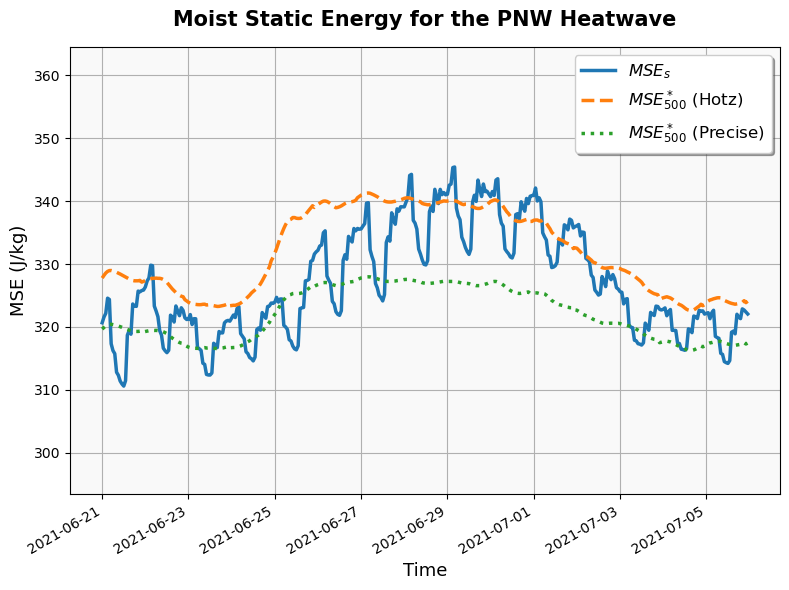

In [61]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Compute the means over lon/lat
mse_surface_mean = mse_surface_all.mse.mean(["lon", "lat"])
mse_sat_mean = mse_sat_all.mse_sat.mean(["lon", "lat"])
mse_sat_precise_mean = mse_sat_precise_all.mse_sat.mean(["lon", "lat"])

# Create figure
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Plot time series with distinct styles
mse_surface_mean.plot(ax=ax, color="#1f77b4", linewidth=2.5, label=r"$MSE_s$")
mse_sat_mean.plot(ax=ax, color="#ff7f0e", linewidth=2.5, linestyle="--", label="$MSE^*_{500}$ (Hotz)")
mse_sat_precise_mean.plot(ax=ax, color="#2ca02c", linewidth=2.5, linestyle=":", label=r"$MSE^*_{500}$ (Precise)")

# --- Formatting ---
ax.set_title("Moist Static Energy for the PNW Heatwave", fontsize=15, pad=15, weight="bold")
ax.set_xlabel("Time", fontsize=13)
ax.set_ylabel("MSE (J/kg)", fontsize=13)

# Add gridlines
ax.grid()

# Add legend
ax.legend(frameon=True, fancybox=True, shadow=True, fontsize=12, loc="best")

# Optional: set y-limits (auto or manual)
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin * 0.95, ymax * 1.05)

# Optional: shaded background for visual contrast
ax.set_facecolor("#f9f9f9")

# Tight layout
plt.tight_layout()
plt.show()